# Load libraries 

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import scipy.io
import os
import sys
from pathlib import Path
import pickle
from gc import collect
from glob import glob
from datetime import datetime
import traceback
from time import sleep
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable


#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/nokni/work/MHDTurbPy/")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data


""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs
from   SEA import SEA


os.path.join(os.getcwd(), 'functions','downloading_helpers' )
from PSP import  download_ephemeris_PSP


# Better figures
from matplotlib import pyplot as plt
plt.style.use(['science', 'scatter'])
plt.rcParams['text.usetex'] = True

# Download data
    Notes:
    - When you request magnetic field data with a resolution (dt) greater than 250 ms, lower resolution data will be downloaded. This is preferred in cases where you want to synchronize magnetic and particle data to mitigate aliasing.
    - SCAM for PSP does not work great because it doesnt download all the files needed (Fix!)
    

In [ ]:
# Choose PSP or SolO
sc                      = 0                                    # PSP:0, SolO:1

# If you only need to download 1 interval (dates wont matter if only_one_interval=0)
only_one_interval       = 1                                    # If you only want to check one interval
if sc==0:
    vars_2_downnload = {'mag': None, 'span': None,'span-a': None, 'spc': None, 'qtn': None, 'ephem': None}
    # vars_2_downnload = {'mag'   : ['B_SC'],
    #                 'span'  : ['DENS',  'VEL_SC', 'TEMP' , 'SUN_DIST', 'SC_VEL_RTN_SUN'],
    #                 'span-a': None,
    #                 'spc'   : None,
    #                 'qtn'   : None,
    #                 'ephem' : None}
elif sc==1:
    vars_2_downnload = {'mag': None, 'qtn': None, 'swa': None, 'ephem': None} 
else:
    print('Not ready yet!')
    
starting_date           = '2018-10-31 01:01:09'                   # Define starting and ending date of the interval
ending_date             = '2018-11-13 01:55:25'

# on the other hand if you have a list of intervals
load_path               = '/Users/nokni/work/MHDTurbPy/example/' # In case you have multiple days you want to download ()


cdf_lib_path            = '/Applications/cdf/cdf/lib'            # You will need to read cdf files. You have to specify the path
choose_working_dir      = '/Users/nokni/work/sc_data/'           # Working dir. Usually where you save raw data (a psp_data, and/or solar_orbiter_data folder will be created)
save_path               = 'data/'                                # This will be connected with the parent of load_path

#User defined parameters
addit_time_around       =  12                                     # [start_time -addit_time_around [h], end_time + addit_time_around [h]]
high_resol_data         = True
subtract_rol_mean       = 1                                      # To estimate fluctuations of mag, vel field
rolling_window          = '1h'                                   # When estimating fluctuations, size of window (centered around -w/2 -w/2
gap_time_threshold      = 5                                      # Threshold for large gaps (units of seconds)
estimate_PSD            = 0                                      # Estimate magentic field powes spectral density (keep false)
estimate_PSD_V          = 0                                      # Estimate velocity field powes spectral density (keep false)
high_res_mag            = 0                                      # Use high resol or low resolution magnetic field data ( Choose either 1 or 0 respectively)
in_RTN                  = 1                                      # RTN or spacecraft frame ( We will usually use RTN)
f_min_spec              = 2e-3                                   # Integrate over [f_min_spec, f_max_spec]to estimate σc, σr 
f_max_spec              = 1e-2                                   #
step                    = '12H'                                  # Move starting point by step (in Hours)
duration                = '24H'                                  # Duration of interval (in Hours)
settings                =  {
                            'particle_mode': 'SPC',    # either: 'spc', 'span', '9th_perih_cut'
                            'use_hampel'   : False,              # Use hampelfilter to despike plasma data
                            'part_resol'   : 1000,                # Max resol of plasma data                [ms]
                            'MAG_resol'    : 500                   # Max resol og magnetic field data        [ms]

                            } 
credentials         = { 'psp':{
                               'fields': {'username': None, 'password': None},
                               'sweap' : {'username': None, 'password': None}
                              }
                      }



# Change to to specified working dir
os.chdir(choose_working_dir)

if only_one_interval:
    df                      =  pd.DataFrame(    index = np.arange(1),
                                                data  = { 'Start' : pd.Timestamp(starting_date), 
                                                          'End'   : pd.Timestamp(ending_date)}
                                           )
else:
    df                      =  pd.read_pickle(load_path)

# Define final path

final_path              =  Path(load_path).joinpath(save_path)

# Run main loop
for ok in range(0,len(df)):
    # Print progress
    func.progress_bar(ok, len(df))

    t0 = df['Start'][ok]
    t1 = df['End'][ok]

    """Setup for main function"""
    tstarts, tends, tfmt, path0  = calc.set_up_main_loop(final_path, only_one_interval,t0, t1, step, duration)

    # Load dist_df of SolO. Stupid way to do it fix later!!
    dist_df            = pd.read_pickle(str(Path(load_path).joinpath("ephem_data").joinpath("SolO_ephem.pkl")))

    """ Now run main for loop! """
    for i1 in range(len(tstarts)):
        start_time  = tstarts[i1]
        end_time    = tends[i1]
        
        # Define folder name
        foldername  = "%s_%s_sc_%d" %(str(start_time.strftime(tfmt)), str(end_time.strftime(tfmt)), 0)

        if not os.path.exists(path0.joinpath(foldername)):
            # Running the main function
            big_gaps, flag_good, final, general, sig_c_sig_r_timeseries, dfdis = calc.final_func(
                                                                                            start_time         , 
                                                                                            end_time           , 
                                                                                            addit_time_around  ,
                                                                                            settings           , 
                                                                                            vars_2_downnload   ,
                                                                                            cdf_lib_path       ,
                                                                                            credentials        ,
                                                                                            gap_time_threshold ,
                                                                                            estimate_PSD_V     ,
                                                                                            subtract_rol_mean  ,
                                                                                            rolling_window     ,
                                                                                            f_min_spec         ,
                                                                                            f_max_spec         ,  
                                                                                            estimate_PSD       , 
                                                                                            sc                 , 
                                                                                            high_resol_data    ,
                                                                                            in_RTN             ,
                                                                                          )
            try:
                final['Par']['V_resampled'] = final['Par']['V_resampled'].join(func.newindex(dfdis[['sc_vel_r', 'sc_vel_t', 'sc_vel_n']], final['Par']['V_resampled'].index))

            except:
                pass

            if flag_good == 1:# (save...)

                if os.path.exists(path0.joinpath(foldername)):
                    print("%d out of %d finished" %(i1, len(df)))
                    continue
                try:
                    os.makedirs(path0.joinpath(foldername), exist_ok=True)

                    pickle.dump(final,open(path0.joinpath(foldername).joinpath("final_data.pkl"),'wb'))
                    pickle.dump(general,open(path0.joinpath(foldername).joinpath("general.pkl"),'wb'))
                    pickle.dump(sig_c_sig_r_timeseries,open(path0.joinpath(foldername).joinpath("sig_c_sig_r.pkl"),'wb'))

                except:
                    os.makedirs(path0.joinpath(foldername), exist_ok=True)
                    print("%s - %s failed!" %(i1, len(tstarts)))

                print("%d out of %d finished" %(i1, len(tstarts)))
            else:
                os.makedirs(path0.joinpath(foldername), exist_ok=True)
                print("%s - %s failed!" %(i1, len(tstarts))) 
        else:
            final                  = pd.read_pickle(str(path0.joinpath(foldername).joinpath("final_data.pkl")))
            general                = pd.read_pickle(str(path0.joinpath(foldername).joinpath("general.pkl")))
            sig_c_sig_r_timeseries = pd.read_pickle(str(path0.joinpath(foldername).joinpath("sig_c_sig_r.pkl")))

In [20]:
final

NameError: name 'final' is not defined

# Visualize data

22-Mar-23 14:21:53: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
22-Mar-23 14:22:21: /Users/nokni/work/MHDTurbPy/functions/Figures.py:660: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



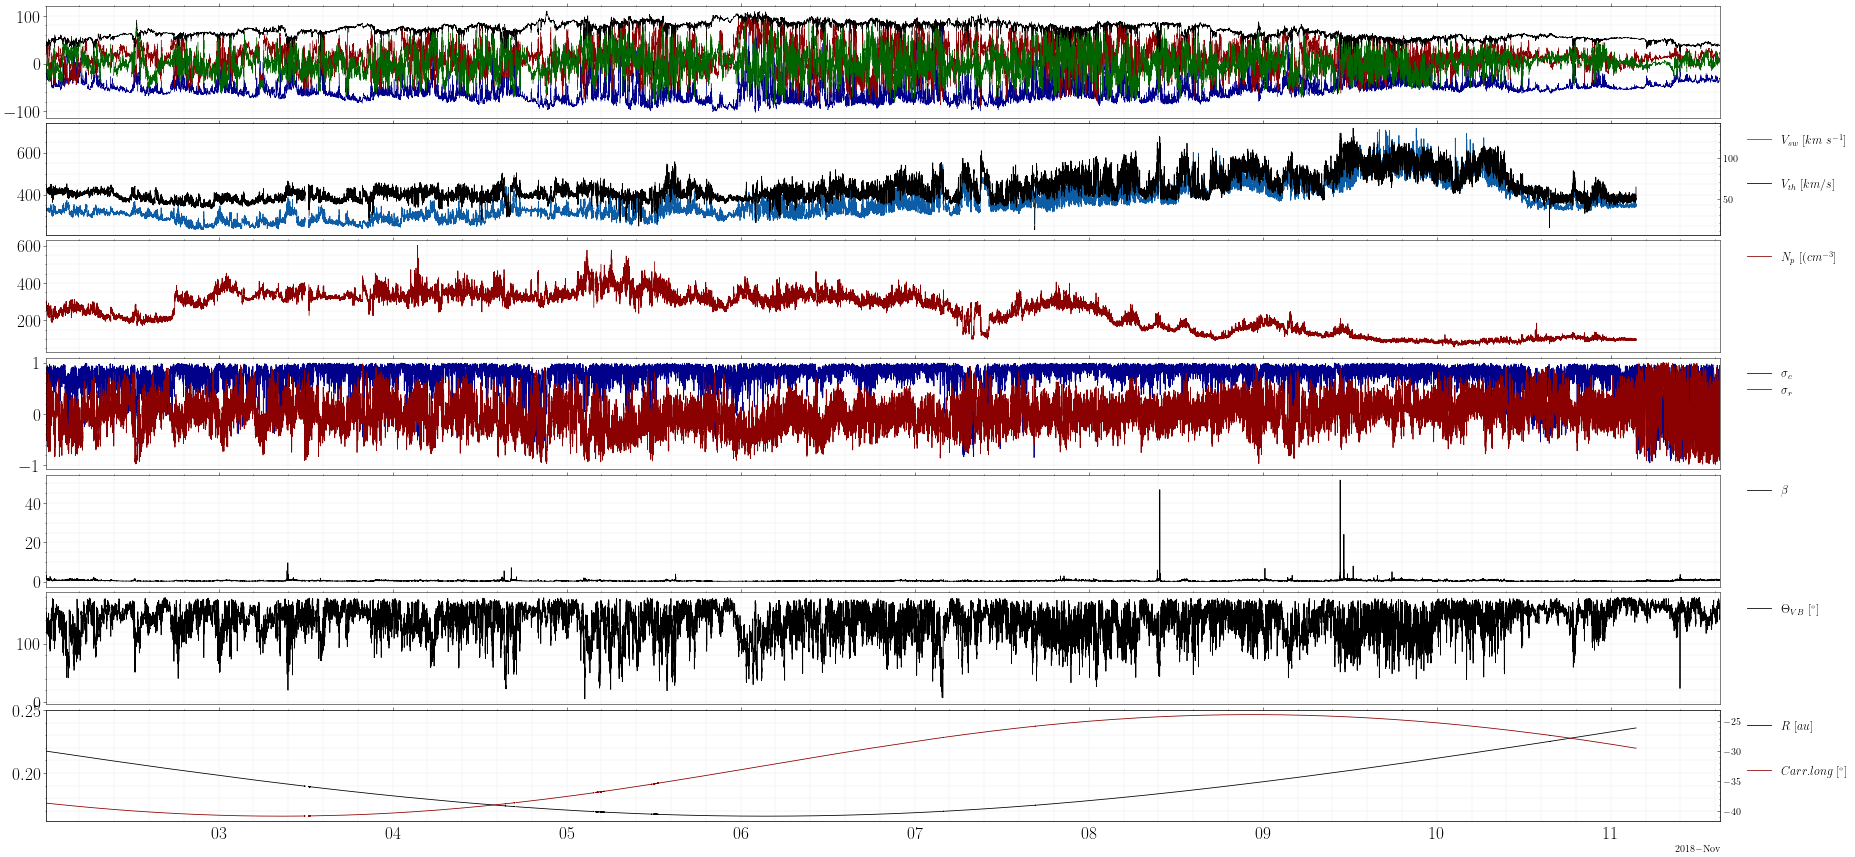

In [4]:
# user defined parameters
size              = 21                                    # labels etc
inset_f_size      = 20                                    # Not needed 
numb_subplots     = 7                                     # number os subplots
my_dir            = '/Users/nokni/work/MHDTurbPy/example' #
format_2_return   = "%Y_%m_%d"                            # Format to save figures
res_rate          = 10                                     # Resample timeseries [seconds]


figs.visualize_downloaded_intervals(
                                  sc                         ,
                                  final['Par']['V_resampled'],
                                  final['Mag']['B_resampled'],
                                  sig_c_sig_r_timeseries     ,
                                  rolling_window             ,
                                  res_rate,
                                  my_dir,
                                  format_2_return ="%Y_%m_%d",  #
                                  size             = 21,
                                  inset_f_size     = 20,
                                  numb_subplots    = 7
                                 )



# Estimate Power Spectral Density (PSD) of the magnetic field.
 - When using high resolution data, 'smoothing_function' is going to be slow!

In [23]:
# User defined parameters
B_df                   = final['Mag']['B_resampled']
V_df                   = final['Par']['V_resampled']


# Morlet wavelet parameters
dj                     = 1/4
per_thresh, par_thresh = 80, 10

# Estimate cadence of mag field timeseries
dt                     = func.find_cadence(B_df)

# Estimate morlet-wavelet PSD. Also decompose into perp, parallel spectrumn
db_x, db_y, db_z, angles, VBangles, freqs, PSD, phys_scales, scales  = turb.estimate_wavelet_coeff(B_df,
                                                                                      V_df, 
                                                                                      dj , 
                                                                                      lambdaa=3
                                                                                     )
# Estimate perp and par spectra
PSD_par, PSD_per                                        = turb.estimate_anisotropic_PSD_wavelets(db_x, 
                                                                                                   db_y, 
                                                                                                   db_z, 
                                                                                                   VBangles.values, 
                                                                                                   freqs,   
                                                                                                   dt,  
                                                                                                   per_thresh, 
                                                                                                   par_thresh
                                                                                                  )

# Estimate FFT trace PSD
fft_freqs, fft_PSD                                      = turb.TracePSD(B_df.Br.values, 
                                                                        B_df.Bt.values, 
                                                                        B_df.Bn.values, 
                                                                        dt
                                                                       )

# Also provide smoothed FFT PSD (Using a window of size 2)
F_mid, F_mean,  smoothed_FFT_PSD                        = func.smoothing_function(fft_freqs, 
                                                                                  fft_PSD
                                                                                 )

# Plot PSD

29-Jan-23 06:51:49: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)



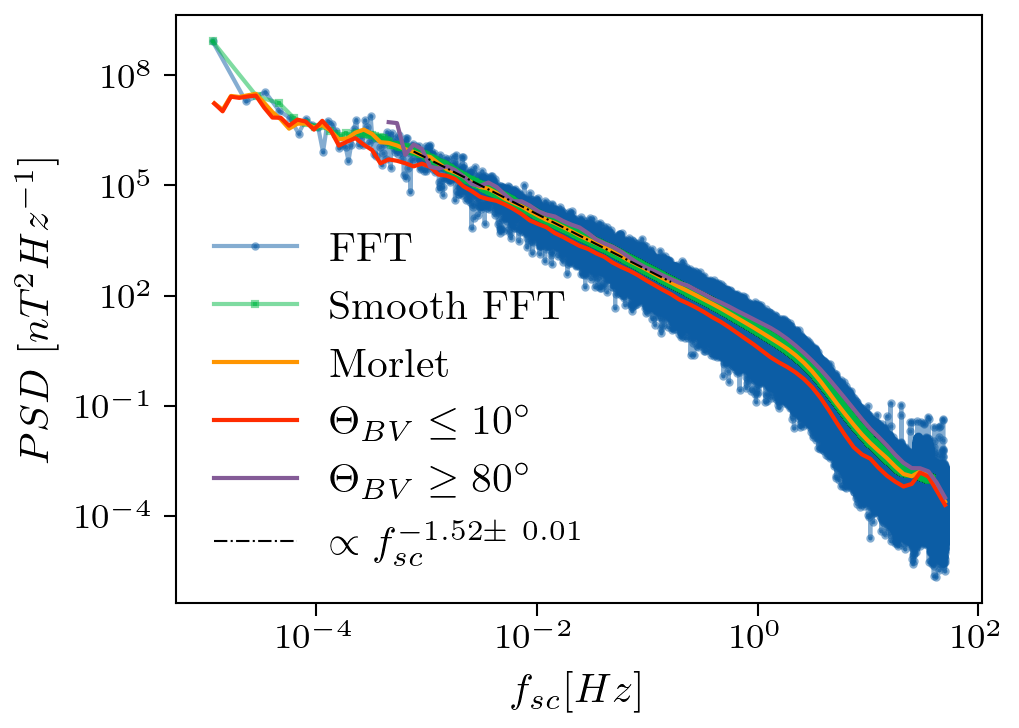

In [27]:
# Define limits of p-law fit
x0, xf                 = 8e-4, 2e-1
inset_f_size           = 10



# Define figure labels
ylabel, xlabel = r'$PSD~ [nT^{2} Hz^{-1}]$', r"$f_{sc} [Hz]$"


# init Figure
fig, ax                              = figs.initializeFigure(ylabel, xlabel, '1col')
minor_tick_params, major_tick_params = figs.inset_axis_params(size = inset_f_size)


# Plot Trace FFT PSD
ax.loglog(fft_freqs, fft_PSD, ls='-', ms=1, alpha=0.5, label ='FFT')
# Plot  smoothed Trace FFT PSD
ax.loglog(F_mean,   smoothed_FFT_PSD, ls='-', ms=1, alpha=0.5, label ='Smooth FFT')

# Plot morlet wavelet PSD
ax.loglog(freqs, PSD,ls='-',ms=0, label ='Morlet')

# Plot morlet prallel wavelet PSD,
leg_par =r'$\Theta_{BV} \leq {%d}^{\circ} $'  %(par_thresh)
ax.loglog(freqs, PSD_par,ls='-',ms=0, label =leg_par)

# Plot morlet perpendicular wavelet PSD
leg_per =r'$\Theta_{BV} \geq {%d}^{\circ} $'  %(per_thresh)
ax.loglog(freqs, PSD_per,ls='-',ms=0, label =leg_per)

# Apply p-law fit on 
fit1, s1, e1, x1, y1  = func.find_fit(freqs,PSD, x0, xf)
# Define legend
lab_name =r'$\propto  f_{sc}^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit1[0][1],2), round(np.sqrt(fit1[1][1][1]),2))

ax.loglog(x1[s1:e1],fit1[2], 'k-.', lw=0.5,label=lab_name)


# axins2 = ax.inset_axes([0.64, 0.61, 0.35, 0.35])
# axins2.yaxis.set_label_position("left")
# axins2.xaxis.set_label_position("bottom")
# axins2.yaxis.tick_left()
# axins2.xaxis.tick_bottom()

# axins2.tick_params(**minor_tick_params)
# axins2.tick_params(**major_tick_params)


ax.legend()

# Estimate PVI Timseries

(0.0, 27.290468876496455)

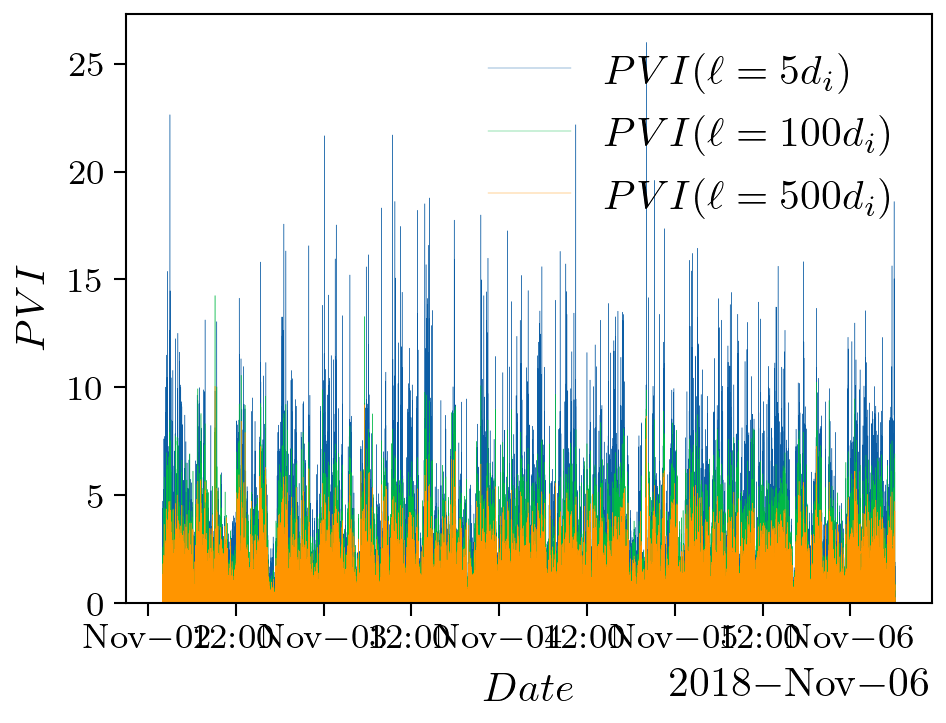

In [5]:
# User defined parameters
hours                  = 4                             # Averaging window in denominator (Hours)
hmany                  = [5, 100, 500]               # Estimate PVI timeseries using a lag of \ell =hmany*di
B_df                   = final['Mag']['B_resampled']
V_df                   = final['Par']['V_resampled']

#
di                     = final['Par']['di_mean']       # Mean value of ion inertial length for the interval
Vsw                    = final['Par']['Vsw_mean']      # Mean value of Solar wind speed  for the interval

# Define figure labels
ylabel, xlabel         = r'$PVI$',  r"$Date$"
inset_f_size           = 7



# Run function
PVI_ts                 =turb.estimate_PVI(B_df,
                                           hmany, 
                                           di,
                                           Vsw,
                                           hours,
                                           PVI_vec_or_mod='vec'
                                          )


# init Figure
fig, ax  = figs.initializeFigure(ylabel, xlabel, '1col')

for kk in range(len(hmany)):
    ax.plot(PVI_ts['PVI_'+str(hmany[kk])], ls='-', ms=0, lw=0.1, label =r'$PVI(\ell= {%d} d_{i})$'%(hmany[kk]))
    
    # # Estimate PDF of PVI
    # res =func.pdf(PVI_ts['PVI_'+str(hmany[kk])].dropna().values, nbins, loglog, density)
    # ax2.semilogy(res[0], res[1], ls='-', ms=0, lw=0.1,c ='C'+str(kk))
    # ax2.set_ylabel(r'$p(PVI)$')
    # ax2.set_ylabel(r'$PVI$')
    


ax.legend(loc=0, )
ax.set_ylim([0,None])


# Superposed epoch analysis
- For more information check (https://github.com/nsioulas/SEA)


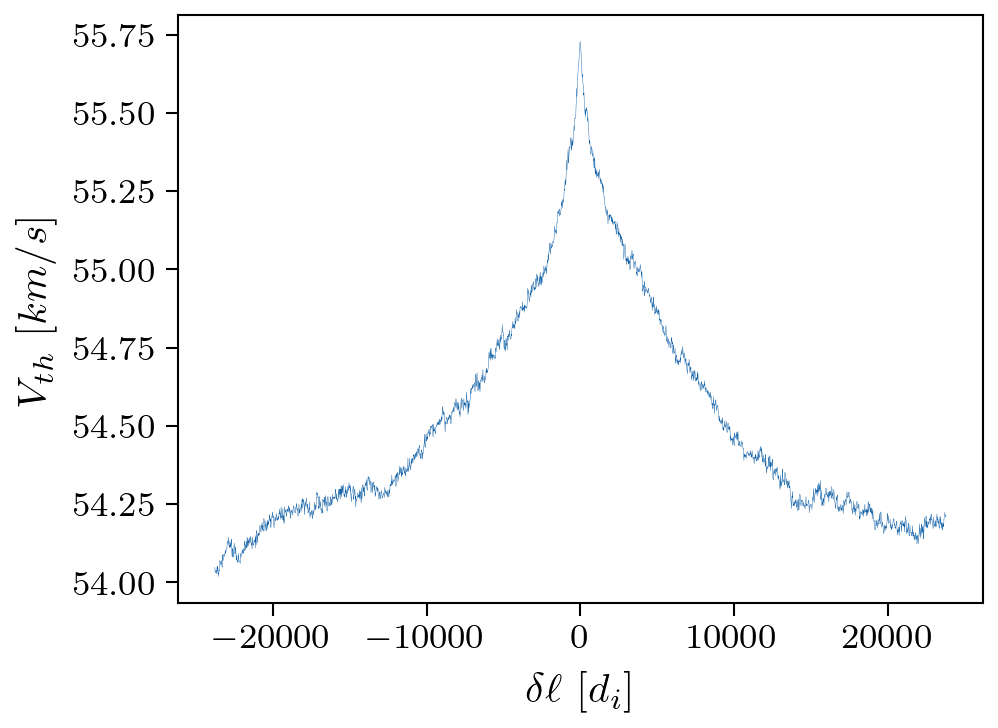

In [6]:
# user defined parameters
time_around        = '1000s'   # Time around identified events
which_one          =  'Vth'    # Parameter to be plotted on y axis
mean_or_median     =  0        # Estimate mean (1) or median (0) of events
resample_rate      =  '800ms'  # Cadence of joined timeseries

# you can actually aplly multiple conditions
condit_variables   = ['PVI_5']#, 'sigma_r']
conditions         = [['>=']]#, ['>=','<='] ]
threshold_values   = [[1]]#, [-0.15, 0.1]]


ylabel, xlabel     = r'$V_{th} ~[km/s]$',  r"$\delta \ell ~[d_i]$"


# Merge the two dfs
f_df = PVI_ts.resample(resample_rate ).mean().join(
     V_df.resample(resample_rate ).mean()
)


# run SEA function
xvals, yvals, y_std, y_std_err_mean  = SEA(f_df,
                                          condit_variables,
                                          threshold_values,
                                          conditions,
                                          time_around,
                                          which_one,
                                          mean_or_median,
                                          resample_rate)



# convert temporal lag to spatial and normalize with di
di_lag    = Vsw*xvals/di

# init Figure
fig, ax   = figs.initializeFigure(ylabel, xlabel, '1col')

ax.plot(di_lag, yvals, ls='-', ms=0, lw=0.1)
    

# Estimate 2-point, 5-point Structure Functions ($SF^{q}$) and Scale dependent Kyrtosis


In [ ]:
max_hours      = 2
max_qorder     = 8
use_5pt_sfuncs = True # True: 5-point Sfuncs, False: 2 point Sfuncs
estimate_SDK   = True # Also keep scale dependent kurtosis

# Find cadence of magnetic field timeseries

dt = func.find_cadence(B)

# Define lags to estimate Sfuncs
max_lag     = int((max_hours*3600)/dt)
tau_values  = 1.2**np.arange(0, 1000)
max_ind     = (tau_values<max_lag) & (tau_values>0)
taus        = np.unique(tau_values[max_ind].astype(int))

# Run main function
sfuncs, sdk = structure_functions_parallel(B,
                                          taus,
                                          max_qorder,
                                          five_points_sfunc = use_5pt_sfuncs,
                                          keep_sdk          = estimate_SDK
                                           )

# Estimate lags in di units
ell_di = (taus*dt)*Vsw/di